# TP 5 Réseaux de neurones - Multi classification et Propagation en avant
Dans ce TP, nous aimerions faire une classification multiclasse. Pour ce faire, nous allons comparer entre une classification utilisant la regression logistique, et une classification en utilisant les réseaux de neurones.

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

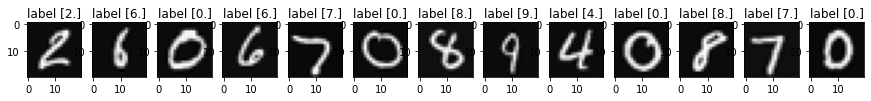

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

# Partie 1, régression logistique
Dans cette partie, nous aimerions utiliser la régression logistique pour classifier nos images

Rappelons que la régression logistique nous donne la probabilité d'appartenance (oui ou non) à la classe 1 (elle permet une classification binaire).

Pour étendre la régression logistique à une multi-classification, nous allons utiliser une stratégie 1 contre tous.

Nous paramètres $\theta$ seront donc une matrice avec un nombre de lignes égale au nombre de classes, et avec un nombre de colones égale au nombre decaractéristiques (chaque ligne de la matrice $\theta$ correspond aux paramètres d'un classifieur.

In [10]:
def Sigmoid(z):
    return 1 / (1 + np.exp(-z));

In [6]:
def lrCostFunction(X, y, initial_theta, alpha, max_iter,lambda_):
    # dans cette fonction vous devez appliquer la regression logistique avec tout ce que ceci implique
    # calcul du coût, minimisation du coût avec descente du gradient, et retour des paramètres theta pour une classe
    theta = np.array(initial_theta, copy=True)
    for i in range(max_iter):
        y_hat = Sigmoid(X @ theta) #model
        error = y_hat - y  #erreur
        theta_grad = np.expand_dims((X * error).mean(axis=0), axis=1) #1/m sum((h-y)*X)
        theta[0] = theta[0] - alpha * theta_grad[0]
        theta[1:] = theta[1:] * (1 - lambda_ * alpha / X.shape[0]) - alpha * theta_grad[1:]
    return theta.T



In [7]:
def predictOneVsAll (all_theta, X):
    # ici en utilisant les paramètres calculés par la régression logisitique, 
    # nous aiemrions retourner les etiquettes predites
    
    # Ici chaque classifieur retournera une de probabilité, il faudra choisir la probabilité maximale 
    # de tous les classifieurs d'une exemple donné
    # répeter pour tous les exmemples
    
    y_pred = np.argmax(Sigmoid(X @ all_theta.T), axis=1) #get indices of max val
    
    return classes[y_pred[..., np.newaxis]]

In [8]:
classes= np.unique(y)
number_classes=classes.shape[0]
all_theta = np.zeros((number_classes, X.shape[1]));
all_theta.shape

(10, 401)

In [11]:
MaxIter= 10000
lambda_= 0.1
alpha = 0.01
# initial_theta pour chaque classifieur
initial_theta=np.zeros((X.shape[1], 1));
for i in range (number_classes):
     # appel pour chaque classifieur
     theta = lrCostFunction(X,(y==classes[i]).astype(int),initial_theta,alpha, MaxIter,lambda_);
     all_theta[i,:]=theta;                      

In [12]:
y_pred = predictOneVsAll(all_theta, X);

# Qualité du classifieur RL

Prédire des valeurs de y

Ici il serait interessant de calculer la précision de notre classifieur

Essayons de calculer ça avec 

moyenne(y==y-pred) * 100

Ceci donnera un pourcentage de precision

In [13]:
precision = np.mean(y==y_pred)*100
precision


89.92

# Partie 2: Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [14]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [15]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [16]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

**Prédiction**

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [29]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    
    h1_output = Sigmoid(X @ W1.T)
    
    intercept = np.ones((X.shape[0],1))
    
    h2_input = np.column_stack((intercept, h1_output))
    
    h2_output = Sigmoid(h2_input @ W2.T)
    
    y_pred = np.argmax(h2_output, axis=1)[..., np.newaxis]
    
    # the neuron outputing probability for 0 class is at the end :( ...
    y_pred = y_pred + 1
    y_pred[y_pred==10] = 0
    return y_pred

In [30]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1, W2, X)
precision = np.mean(y==y_pred)*100
precision

97.52

In [31]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=int64)

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Renforcement d'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 22 Avril 2022 à 22h


In [ ]:
# bonne chance